импорт всех нужных библиотек

In [1]:
from sklearn.model_selection import train_test_split
import torch
import sys
import os
from model import KANTrainer
from kan import *

import matplotlib.pyplot as plt
#путь к корню директории
BASE_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.abspath(BASE_DIR))
from data_preparation import PreparationDataset
from show_analysis import LossVisualizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Загрузка и подготовка данных для анализа и обучения модели.<br>
разбиение на train,test


In [2]:
path = BASE_DIR + '\data_all'  # Путь к данным
PD = PreparationDataset(path)

# параметры подготовки данных
pd_params = (4,9,50,1)
window_size,num_features,downsample_step,target_window_size = pd_params 

# Подготовка данных
X, y, df = PD.vec_to_vec(
    window_size,
    num_features,
    downsample_step,
    target_window_size,
    device=device  
)

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
dataset = {'train_input':X_train, 'test_input':X_test, 'train_label':y_train, 'test_label':y_test}
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([15533, 35]),
 torch.Size([7651, 35]),
 torch.Size([15533, 1]),
 torch.Size([7651, 1]))

In [24]:
#инициализация модели
model = KAN(width=[30,20], grid=15, k=10, noise_scale=0.3, seed=2,device = device)

trainer = KANTrainer(
    model=model,
    learning_rate=1e-256,
    device= device
)

checkpoint directory created: ./model
saving model version 0.0


In [25]:
history = trainer.fit(
    X=X_train,
    y=y_train,
    X_t=X_test,
    y_t=y_test,
    batch_size=16,
    epochs=30,
    loss_tube=5
)

| train_loss: 1.47e+01 | test_loss: 1.93e+01 | reg: 8.83e+02 | : 100%|█| 30/30 [00:09<00:00,  3.33it

saving model version 0.1


In [26]:
losses=  {
            'train_main_loss': history['train_loss'],
            'train_mape': torch.zeros((len(history['mape']))),
            'test_mape': history['mape'],
            'test_tube': history['tube']
            }

In [27]:
LV = LossVisualizer(losses)

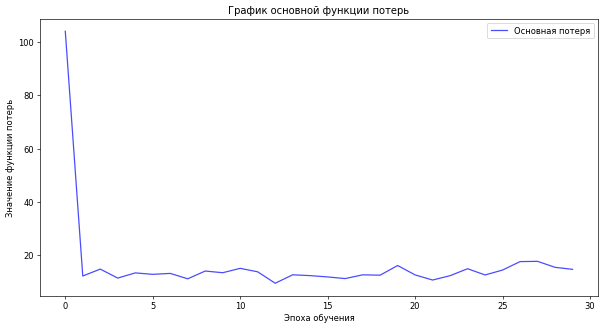

In [28]:
LV.show_training_loss()

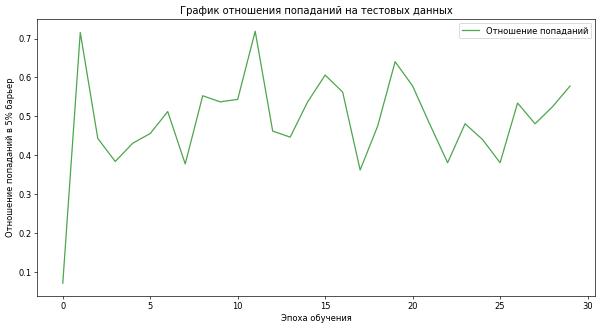

In [29]:
LV.show_test_tube()

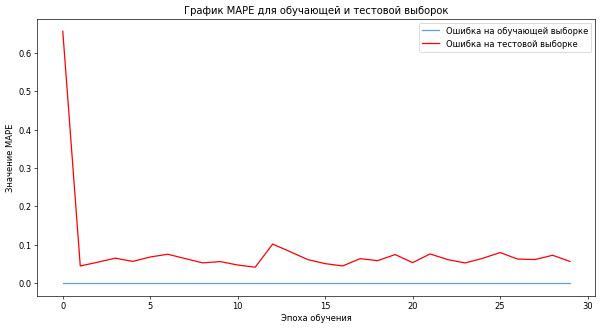

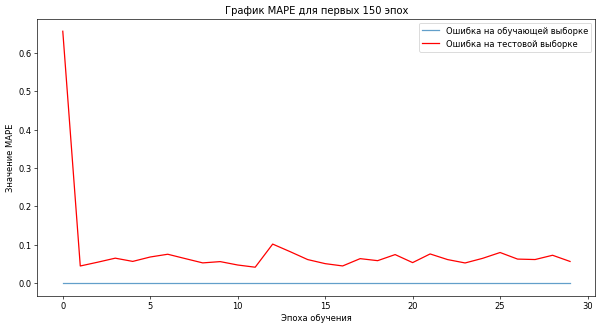

In [30]:
LV.show_mape()

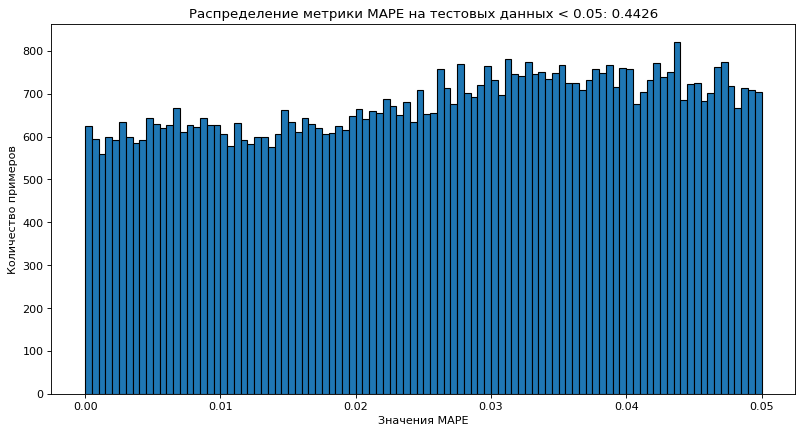

Процент значений MAPE < 0.05: 0.4426


In [32]:
LV.histogram_mape(model,X_test,y_test,limit_percel = 5)

Количество записей: 5334


ValueError: x and y must be the same size

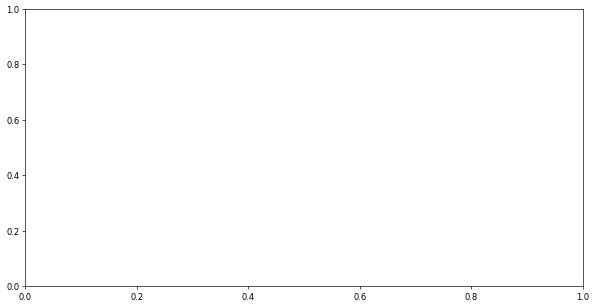

In [12]:
LV.show_predictions(model,df,pd_params,device)